In [ ]:
!pip install -q keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.9 MB/s eta 0:00:00


**Imports**

In [ ]:
import os
import shutil
import random
from collections import defaultdict, Counter
import zipfile

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.mixed_precision import set_global_policy
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import TrainingArguments, Trainer


from tensorflow.keras.applications import (
    InceptionV3,
    ResNet50,
    DenseNet121,
    EfficientNetB0
)

import keras_cv

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu May 22 13:04:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
set_global_policy('mixed_float16')

In [ ]:
zip_path = "/content/drive/MyDrive/archive (11).zip"
output_dir = "/content/drive/MyDrive/LungCancer_before"

In [ ]:
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Unzipped to: {output_dir}")

Unzipped to: /content/drive/MyDrive/LungCancer_before


**Data Split:** *80*-10-10

In [ ]:
def split_dataset(base_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"
    random.seed(seed)

    class_names = os.listdir(base_dir)
    for class_name in tqdm(class_names, desc="Splitting dataset"):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split_name, split_images in splits.items():
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

# Run it
source_dir = "/content/drive/MyDrive/LungCancer_before"
output_dir2 = "/content/drive/MyDrive/LungCancer_after"
split_dataset(source_dir, output_dir2)


Splitting dataset: 100%|██████████| 3/3 [19:50<00:00, 396.88s/it]


In [ ]:
def count_images_per_class(split_dir):
    split_counts = defaultdict(dict)

    for split in ['train', 'val', 'test']:
        path = os.path.join(split_dir, split)
        if not os.path.exists(path):
            print(f"{split} folder not found.")
            continue

        print(f"\nSplit: {split}")
        total = 0
        for class_name in sorted(os.listdir(path)):
            class_path = os.path.join(path, class_name)
            if not os.path.isdir(class_path):
                continue
            count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            split_counts[split][class_name] = count
            total += count
            print(f"  {class_name}: {count}")
        print(f"   Total in {split}: {total}")

    return split_counts

split_path = "/content/drive/MyDrive/LungCancer_after"
counts = count_images_per_class(split_path)



Split: train
  adenocarcinoma: 4000
  benign: 4000
  squamous_cell_carcinoma: 4000
   Total in train: 12000

Split: val
  adenocarcinoma: 500
  benign: 500
  squamous_cell_carcinoma: 500
   Total in val: 1500

Split: test
  adenocarcinoma: 500
  benign: 500
  squamous_cell_carcinoma: 500
   Total in test: 1500


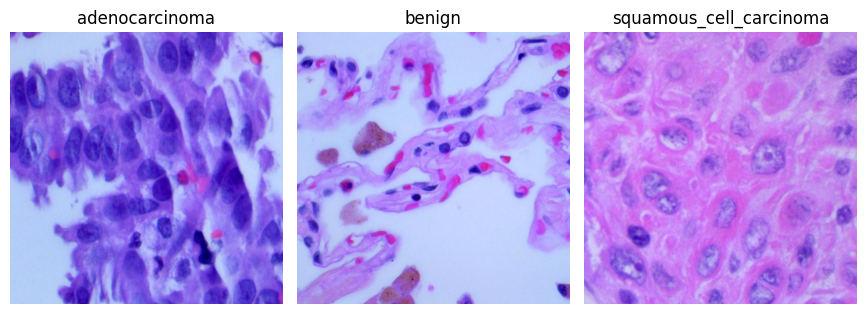

In [ ]:
base_path = "/content/drive/MyDrive/LungCancer_after/train"
classes = os.listdir(base_path)

plt.figure(figsize=(26, 20))
for i, cls in enumerate(random.sample(classes,3)):
    img_name = random.choice(os.listdir(os.path.join(base_path, cls)))
    img_path = os.path.join(base_path, cls, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, 9, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def count_classes(folder):
    class_counts = {}
    for cls in os.listdir(folder):
        class_path = os.path.join(folder, cls)
        if os.path.isdir(class_path):
            class_counts[cls] = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

counts = count_classes("/content/drive/MyDrive/LungCancer_after/train")
print("Class distribution in training set:")
print(counts)

Class distribution in training set:
{'adenocarcinoma': 4000, 'benign': 4000, 'squamous_cell_carcinoma': 4000}


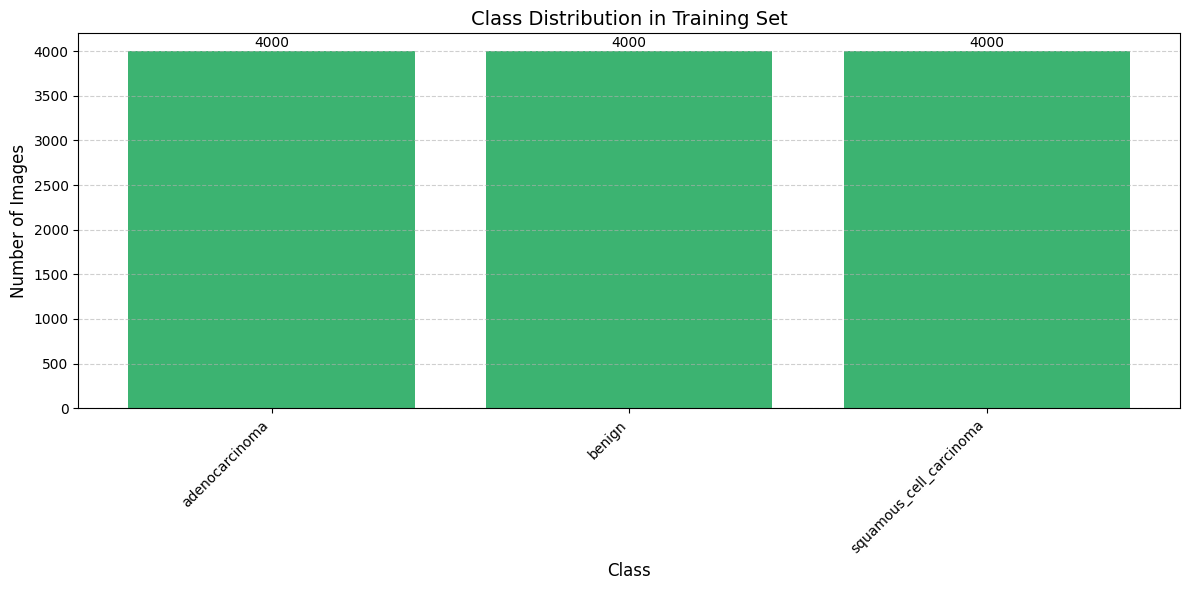

In [ ]:
class_counts = {
 'adenocarcinoma': 4000,
 'benign': 4000,
 'squamous_cell_carcinoma': 4000
}
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='mediumseagreen')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height),
             ha='center', va='bottom', fontsize=10)

plt.title("Class Distribution in Training Set", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    shear_range=5,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/LungCancer_after/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/LungCancer_after/val',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/LungCancer_after/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
print("Train class indices:", train_generator.class_indices)
print("Validation class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Train class indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}
Validation class indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}
Test class indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}


**Inception V3**

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True
# Freeze bottom layers only:
for layer in base_model.layers[:-50]:
    layer.trainable = False

output = GlobalAveragePooling2D()(base_model.output)


output = Dense(1024)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.5)(output)

output = Dense(512)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.3)(output)

output = Dense(3, activation='softmax')(output)


model_incep = Model(inputs=base_model.input, outputs=output)

model_incep.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_inceptionv3_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history_incep = model_incep.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5768 - loss: 0.9099 

188/188 ━━━━━━━━━━━━━━━━━━━━ 2959s 16s/step - accuracy: 0.5775 - loss: 0.9085 - val_accuracy: 0.9087 - val_loss: 0.3563 - learning_rate: 1.0000e-05
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8669 - loss: 0.3427

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8670 - loss: 0.3425 - val_accuracy: 0.9373 - val_loss: 0.1813 - learning_rate: 1.0000e-05
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9135 - loss: 0.2279

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9135 - loss: 0.2278 - val_accuracy: 0.9500 - val_loss: 0.1324 - learning_rate: 1.0000e-05
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9318 - loss: 0.1935

188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9319 - loss: 0.1935 - val_accuracy: 0.9600 - val_loss: 0.1072 - learning_rate: 1.0000e-05
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9405 - loss: 0.1544

188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9405 - loss: 0.1543 - val_accuracy: 0.9653 - val_loss: 0.0897 - learning_rate: 1.0000e-05
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9472 - loss: 0.1416

188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9473 - loss: 0.1416 - val_accuracy: 0.9713 - val_loss: 0.0751 - learning_rate: 1.0000e-05
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9574 - loss: 0.1168

188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9574 - loss: 0.1168 - val_accuracy: 0.9733 - val_loss: 0.0630 - learning_rate: 1.0000e-05
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9620 - loss: 0.1065

188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9620 - loss: 0.1065 - val_accuracy: 0.9773 - val_loss: 0.0538 - learning_rate: 1.0000e-05
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9680 - loss: 0.0877

188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9680 - loss: 0.0877 - val_accuracy: 0.9833 - val_loss: 0.0461 - learning_rate: 1.0000e-05
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9712 - loss: 0.0803

188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9712 - loss: 0.0803 - val_accuracy: 0.9853 - val_loss: 0.0415 - learning_rate: 1.0000e-05
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9727 - loss: 0.0700

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9727 - loss: 0.0700 - val_accuracy: 0.9887 - val_loss: 0.0353 - learning_rate: 1.0000e-05
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9806 - loss: 0.0549

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9806 - loss: 0.0550 - val_accuracy: 0.9893 - val_loss: 0.0313 - learning_rate: 1.0000e-05
Epoch 13/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9771 - loss: 0.0622

188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9771 - loss: 0.0622 - val_accuracy: 0.9907 - val_loss: 0.0267 - learning_rate: 1.0000e-05
Epoch 14/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9803 - loss: 0.0507

188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9803 - loss: 0.0506 - val_accuracy: 0.9913 - val_loss: 0.0256 - learning_rate: 1.0000e-05
Epoch 15/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9848 - loss: 0.0439

188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9848 - loss: 0.0439 - val_accuracy: 0.9927 - val_loss: 0.0215 - learning_rate: 1.0000e-05
Epoch 16/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9844 - loss: 0.0441 - val_accuracy: 0.9933 - val_loss: 0.0219 - learning_rate: 1.0000e-05
Epoch 17/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9903 - loss: 0.0347

188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9903 - loss: 0.0347 - val_accuracy: 0.9927 - val_loss: 0.0215 - learning_rate: 1.0000e-05
Epoch 18/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9872 - loss: 0.0362

188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9872 - loss: 0.0361 - val_accuracy: 0.9953 - val_loss: 0.0191 - learning_rate: 1.0000e-05
Epoch 19/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9901 - loss: 0.0305

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9901 - loss: 0.0305 - val_accuracy: 0.9940 - val_loss: 0.0187 - learning_rate: 1.0000e-05
Epoch 20/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9886 - loss: 0.0333

188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9886 - loss: 0.0333 - val_accuracy: 0.9967 - val_loss: 0.0153 - learning_rate: 1.0000e-05


In [ ]:
inception_path = "/content/drive/MyDrive/lung_cancer_models/inceptionv3_model.h5"
model_incep.save(inception_path)
print("InceptionV3 model saved.")

InceptionV3 model saved.


In [ ]:
model_incep.save("inceptionv3_LungCancer_model.h5")

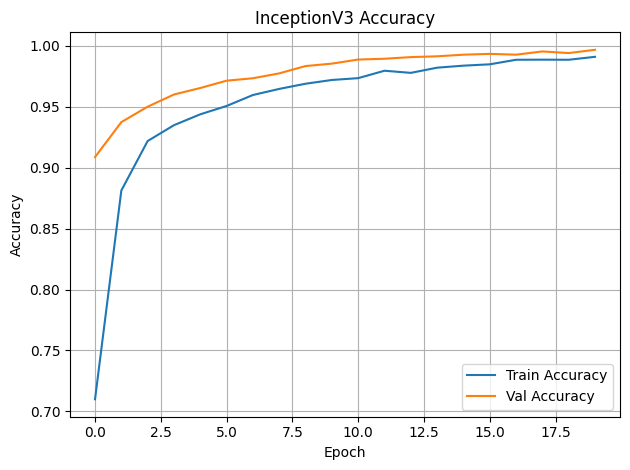

In [ ]:
plt.plot(history_incep.history['accuracy'], label='Train Accuracy')
plt.plot(history_incep.history['val_accuracy'], label='Val Accuracy')
plt.title("InceptionV3 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Final Training Accuracy: {history_incep.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_incep.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history_incep.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_incep.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 0.9909
Final Validation Accuracy: 0.9967
Final Training Loss: 0.0293
Final Validation Loss: 0.0153


24/24 ━━━━━━━━━━━━━━━━━━━━ 439s 19s/step


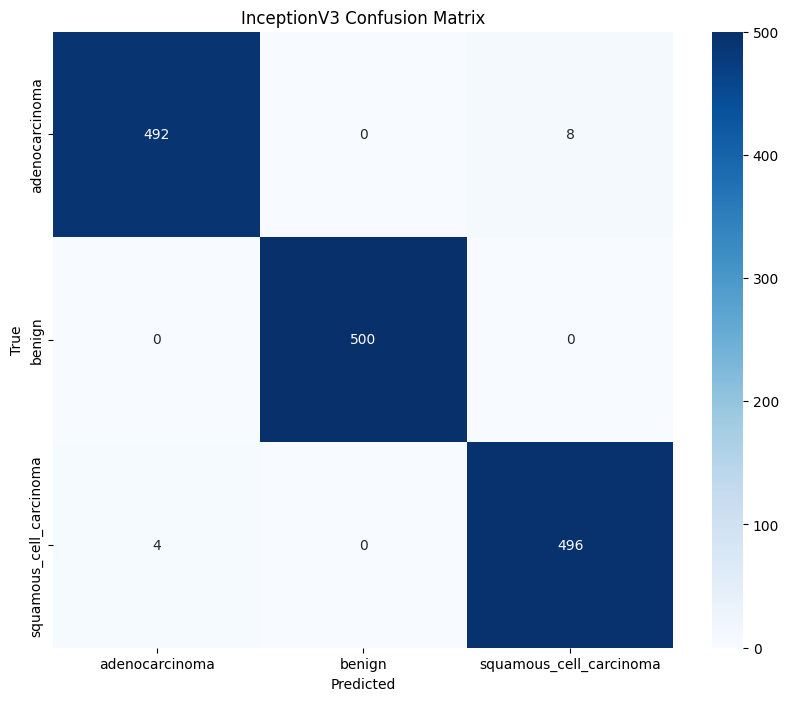

                         precision    recall  f1-score   support

         adenocarcinoma       0.99      0.98      0.99       500
                 benign       1.00      1.00      1.00       500
squamous_cell_carcinoma       0.98      0.99      0.99       500

               accuracy                           0.99      1500
              macro avg       0.99      0.99      0.99      1500
           weighted avg       0.99      0.99      0.99      1500



In [ ]:
y_pred_incep = model_incep.predict(test_generator)
y_pred_incep_classes = np.argmax(y_pred_incep, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_incep_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred_incep_classes, target_names=class_labels))

In [ ]:
loss, accuracy = model_incep.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 0.9856 - loss: 0.0429
Test Loss: 0.0229
Test Accuracy: 0.9920


**ResNet**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
# Freeze bottom layers only:
for layer in base_model.layers[:-50]:
    layer.trainable = False

output = GlobalAveragePooling2D()(base_model.output)
output = Dropout(0.5)(output)
output = Dense(512, activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(3, activation='softmax')(output)

model_resnet = Model(inputs=base_model.input, outputs=output)

model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet50_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6404 - loss: 0.7452

188/188 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.6410 - loss: 0.7441 - val_accuracy: 0.3333 - val_loss: 9.9502 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8377 - loss: 0.3790

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8378 - loss: 0.3789 - val_accuracy: 0.3333 - val_loss: 8.8419 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8536 - loss: 0.3427

188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8536 - loss: 0.3426 - val_accuracy: 0.4513 - val_loss: 5.9612 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8775 - loss: 0.2999 - val_accuracy: 0.3333 - val_loss: 10.7454 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8827 - loss: 0.2856 - val_accuracy: 0.3333 - val_loss: 10.7454 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8920 - loss: 0.2497

188/188 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8920 - loss: 0.2497 - val_accuracy: 0.3433 - val_loss: 5.2673 - learning_rate: 1.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8964 - loss: 0.2506 - val_accuracy: 0.3333 - val_loss: 10.7454 - learning_rate: 1.0000e-04
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8999 - loss: 0.2426 - val_accuracy: 0.3333 - val_loss: 9.0920 - learning_rate: 1.0000e-04
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8998 - loss: 0.2371
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8998 - loss: 0.2371 - val_accuracy: 0.3693 - val_loss: 8.0601 - learning_rate: 1.0000e-04
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9104 - loss: 0.2116

188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9104 - loss: 0.2115 - val_accuracy: 0.8927 - val_loss: 0.2631 - learning_rate: 2.0000e-05
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9211 - loss: 0.1889 - val_accuracy: 0.8053 - val_loss: 0.5061 - learning_rate: 2.0000e-05
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9239 - loss: 0.1820 - val_accuracy: 0.7353 - val_loss: 0.9017 - learning_rate: 2.0000e-05
Epoch 13/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9328 - loss: 0.1671
Epoch 13: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9328 - loss: 0.1672 - val_accuracy: 0.7287 - val_loss: 0.7284 - learning_rate: 2.0000e-05
Epoch 14/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9292 - loss: 0.1645

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9292 - loss: 0.1645 - val_accuracy: 0.9020 - val_loss: 0.2421 - learning_rate: 4.0000e-06
Epoch 15/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9315 - loss: 0.1635

188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9315 - loss: 0.1635 - val_accuracy: 0.9287 - val_loss: 0.1626 - learning_rate: 4.0000e-06
Epoch 16/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9322 - loss: 0.1585 - val_accuracy: 0.9020 - val_loss: 0.2362 - learning_rate: 4.0000e-06
Epoch 17/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9377 - loss: 0.1560 - val_accuracy: 0.9267 - val_loss: 0.1713 - learning_rate: 4.0000e-06
Epoch 18/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9366 - loss: 0.1495
Epoch 18: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
188/188 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9366 - loss: 0.1495 - val_accuracy: 0.9120 - val_loss: 0.2148 - learning_rate: 4.0000e-06
Epoch 19/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9388 - loss: 0.1511

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9388 - loss: 0.1511 - val_accuracy: 0.9407 - val_loss: 0.1380 - learning_rate: 8.0000e-07
Epoch 20/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9388 - loss: 0.1524

188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9388 - loss: 0.1524 - val_accuracy: 0.9420 - val_loss: 0.1366 - learning_rate: 8.0000e-07


In [ ]:
resnet_path = "/content/drive/MyDrive/lung_cancer_models/resnet50_model.h5"
model_resnet.save(resnet_path)
print(" ResNet50 model saved.")


 ResNet50 model saved.


In [ ]:
model_resnet.save("resnet50_LungCancer_model.h5")

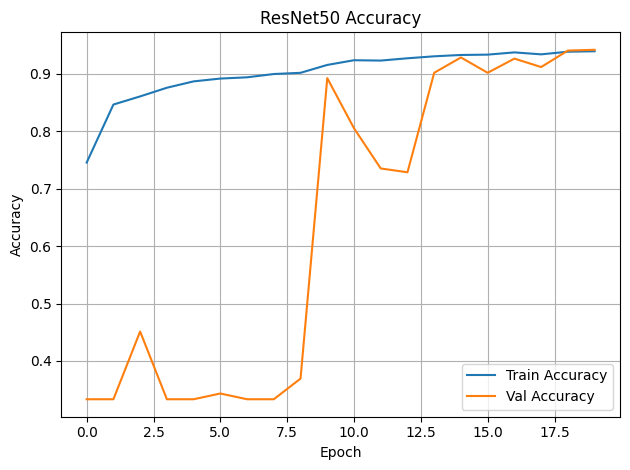

In [ ]:
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title("ResNet50 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Final Training Accuracy: {history_resnet.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_resnet.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history_resnet.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_resnet.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 0.9395
Final Validation Accuracy: 0.9420
Final Training Loss: 0.1521
Final Validation Loss: 0.1366


24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 565ms/step


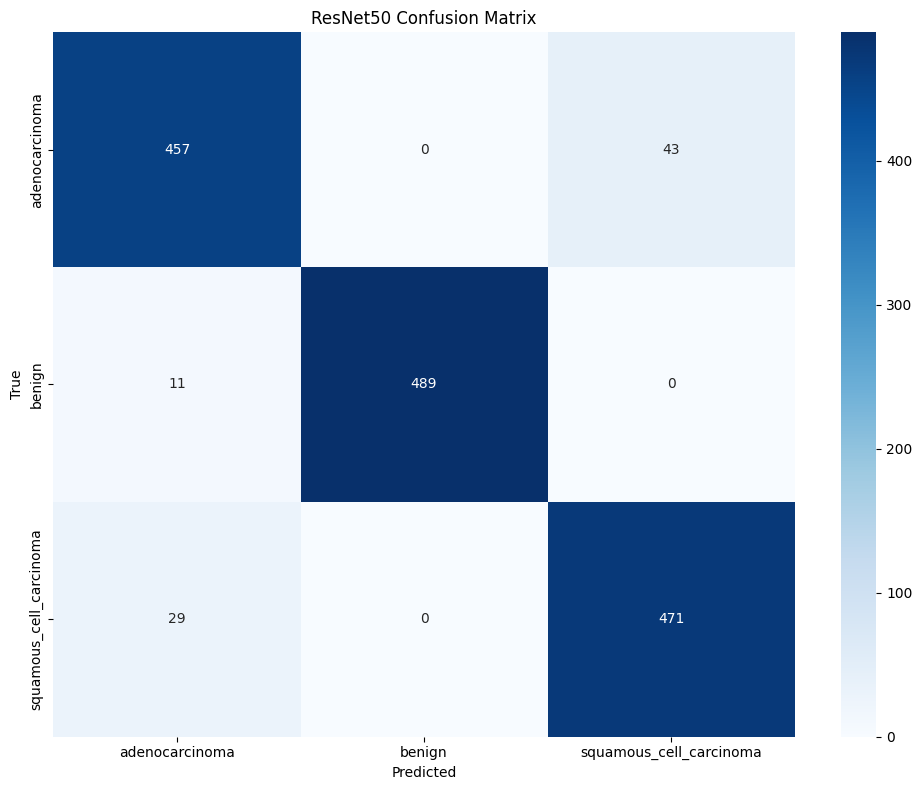

                         precision    recall  f1-score   support

         adenocarcinoma       0.92      0.91      0.92       500
                 benign       1.00      0.98      0.99       500
squamous_cell_carcinoma       0.92      0.94      0.93       500

               accuracy                           0.94      1500
              macro avg       0.95      0.94      0.94      1500
           weighted avg       0.95      0.94      0.94      1500



In [ ]:
y_pred_resnet = model_resnet.predict(test_generator)
y_pred_resnet_classes = np.argmax(y_pred_resnet, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_resnet_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred_resnet_classes, target_names=class_labels))

In [ ]:
loss, accuracy = model_resnet.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.9337 - loss: 0.1646
Test Loss: 0.1347
Test Accuracy: 0.9447


**EfficientNetB0**

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True
# Freeze bottom layers only:
for layer in base_model.layers[:-50]:
    layer.trainable = False

output = GlobalAveragePooling2D()(base_model.output)
output = Dropout(0.5)(output)
output = Dense(512, activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(3, activation='softmax')(output)  # 9 classes

model_effnet = Model(inputs=base_model.input, outputs=output)

model_effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_efficientnetb0_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history_effnet = model_effnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3464 - loss: 1.1222

188/188 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.3465 - loss: 1.1221 - val_accuracy: 0.3333 - val_loss: 1.0990 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.4246 - loss: 1.0388 - val_accuracy: 0.3333 - val_loss: 1.1501 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5186 - loss: 0.8683

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.5186 - loss: 0.8682 - val_accuracy: 0.6233 - val_loss: 0.8865 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.5460 - loss: 0.8189 - val_accuracy: 0.3367 - val_loss: 4.5130 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.5600 - loss: 0.7954 - val_accuracy: 0.4220 - val_loss: 2.5418 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5786 - loss: 0.7684
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.5787 - loss: 0.7684 - val_accuracy: 0.3413 - val_loss: 4.0416 - learning_rate: 1.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6162 - loss: 0.7184 - val_accuracy: 0.3413 - val_loss: 5.4666 - learning_rate: 2.0000e-05
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6413 - l

In [ ]:
effnet_path = "/content/drive/MyDrive/lung_cancer_models/efficientnetb0_model.h5"
model_effnet.save(effnet_path)
print("EfficientNetB0 model saved.")

EfficientNetB0 model saved.


In [ ]:
model_effnet.save("effnet_LungCancer_model.h5")

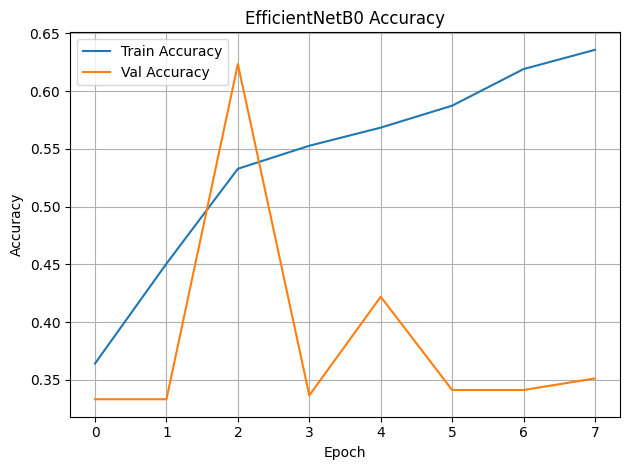

In [ ]:
plt.plot(history_effnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_effnet.history['val_accuracy'], label='Val Accuracy')
plt.title("EfficientNetB0 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Final Training Accuracy: {history_effnet.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_effnet.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history_effnet.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_effnet.history['val_loss'][-1]:.4f}")


Final Training Accuracy: 0.6357
Final Validation Accuracy: 0.3513
Final Training Loss: 0.7001
Final Validation Loss: 5.0392


24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 643ms/step


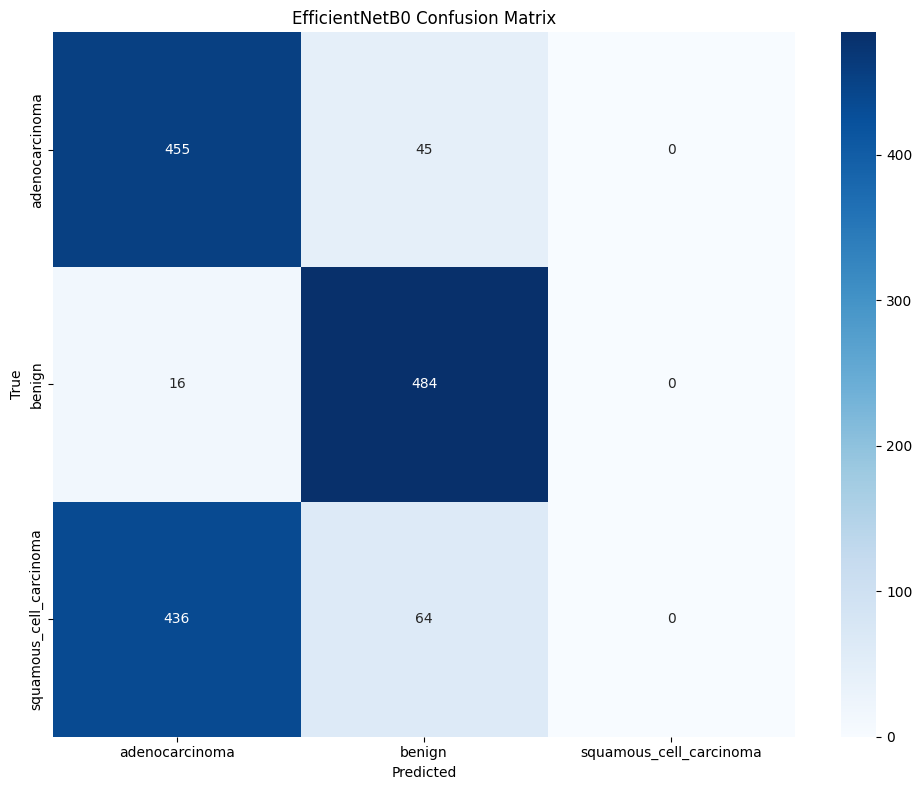

                         precision    recall  f1-score   support

         adenocarcinoma       0.50      0.91      0.65       500
                 benign       0.82      0.97      0.89       500
squamous_cell_carcinoma       0.00      0.00      0.00       500

               accuracy                           0.63      1500
              macro avg       0.44      0.63      0.51      1500
           weighted avg       0.44      0.63      0.51      1500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_pred_effnet = model_effnet.predict(test_generator)
y_pred_effnet_classes = np.argmax(y_pred_effnet, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_effnet_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("EfficientNetB0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred_effnet_classes, target_names=class_labels))


In [ ]:
loss, accuracy = model_effnet.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8397 - loss: 0.5813
Test Loss: 0.8828
Test Accuracy: 0.6260


**DenseNet121**

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True
# Freeze bottom layers only:
for layer in base_model.layers[:-50]:
    layer.trainable = False

output = GlobalAveragePooling2D()(base_model.output)
output = Dropout(0.5)(output)
output = Dense(512, activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(3, activation='softmax')(output)

model_densenet = Model(inputs=base_model.input, outputs=output)

model_densenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_densenet121_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history_densenet = model_densenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7653 - loss: 0.5594

188/188 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.7658 - loss: 0.5581 - val_accuracy: 0.9620 - val_loss: 0.0963 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9429 - loss: 0.1461

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9429 - loss: 0.1460 - val_accuracy: 0.9847 - val_loss: 0.0414 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9694 - loss: 0.0808

188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9694 - loss: 0.0807 - val_accuracy: 0.9893 - val_loss: 0.0278 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9795 - loss: 0.0514

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9795 - loss: 0.0515 - val_accuracy: 0.9940 - val_loss: 0.0158 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9842 - loss: 0.0448

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9843 - loss: 0.0448 - val_accuracy: 0.9980 - val_loss: 0.0057 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9924 - loss: 0.0236 - val_accuracy: 0.9953 - val_loss: 0.0131 - learning_rate: 1.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9932 - loss: 0.0191

188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9932 - loss: 0.0191 - val_accuracy: 0.9987 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9927 - loss: 0.0185

188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9927 - loss: 0.0185 - val_accuracy: 0.9987 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9958 - loss: 0.0117

188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9958 - loss: 0.0117 - val_accuracy: 0.9993 - val_loss: 0.0036 - learning_rate: 1.0000e-04
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9975 - loss: 0.0069

188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9975 - loss: 0.0070 - val_accuracy: 0.9987 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9970 - loss: 0.0084

188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9970 - loss: 0.0084 - val_accuracy: 0.9993 - val_loss: 0.0030 - learning_rate: 1.0000e-04
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9953 - loss: 0.0137 - val_accuracy: 0.9993 - val_loss: 0.0052 - learning_rate: 1.0000e-04
Epoch 13/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9978 - loss: 0.0053

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9978 - loss: 0.0053 - val_accuracy: 0.9993 - val_loss: 0.0028 - learning_rate: 1.0000e-04
Epoch 14/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9970 - loss: 0.0082 - val_accuracy: 0.9933 - val_loss: 0.0184 - learning_rate: 1.0000e-04
Epoch 15/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9981 - loss: 0.0057

188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9981 - loss: 0.0057 - val_accuracy: 0.9993 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 16/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9993 - val_loss: 0.0044 - learning_rate: 1.0000e-04
Epoch 17/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9984 - loss: 0.0041

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9984 - loss: 0.0041 - val_accuracy: 0.9987 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 18/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9987 - loss: 0.0039 - val_accuracy: 0.9973 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 19/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9993 - val_loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 20/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9992 - loss: 0.0030
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9993 - val_loss: 0.0042 - learning_rate: 1.0000e-04


In [ ]:
densenet_path = "/content/drive/MyDrive/lung_cancer_models/densenet121_model.h5"
model_densenet.save(densenet_path)
print("DenseNet121 model saved.")

DenseNet121 model saved.


In [ ]:
model_densenet.save("densenet121_LungCancer_model.h5")

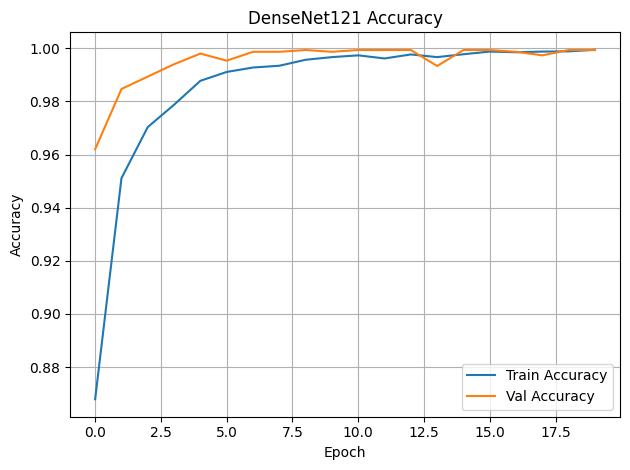

In [ ]:
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Val Accuracy')
plt.title("DenseNet121 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Final Training Accuracy: {history_densenet.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_densenet.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history_densenet.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_densenet.history['val_loss'][-1]:.4f}")


Final Training Accuracy: 0.9994
Final Validation Accuracy: 0.9993
Final Training Loss: 0.0027
Final Validation Loss: 0.0042


24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 807ms/step


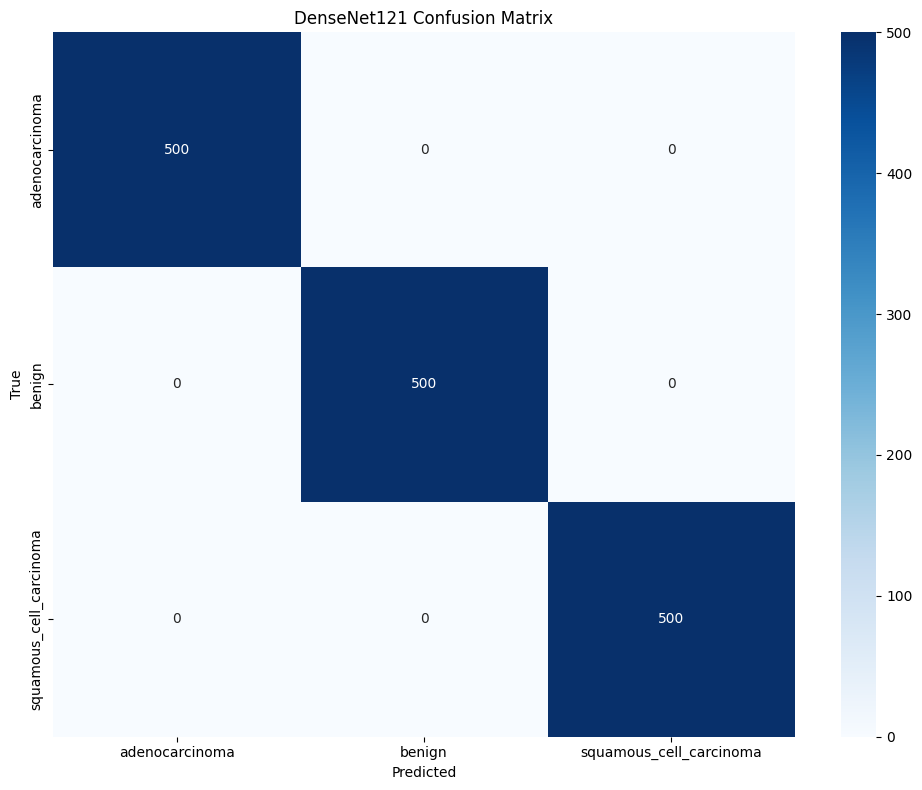

                         precision    recall  f1-score   support

         adenocarcinoma       1.00      1.00      1.00       500
                 benign       1.00      1.00      1.00       500
squamous_cell_carcinoma       1.00      1.00      1.00       500

               accuracy                           1.00      1500
              macro avg       1.00      1.00      1.00      1500
           weighted avg       1.00      1.00      1.00      1500



In [ ]:
y_pred_densenet = model_densenet.predict(test_generator)
y_pred_densenet_classes = np.argmax(y_pred_densenet, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_densenet_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("DenseNet121 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred_densenet_classes, target_names=class_labels))


In [ ]:
loss, accuracy = model_densenet.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 1.0000 - loss: 1.5297e-04
Test Loss: 0.0001
Test Accuracy: 1.0000


**Comparison**

In [ ]:
comparison_data = {
    "Model": ["InceptionV3", "ResNet50", "EfficientNetB0", "DenseNet121"],
    "Train Accuracy": [
        history_incep.history['accuracy'][-1],
        history_resnet.history['accuracy'][-1],
        history_effnet.history['accuracy'][-1],
        history_densenet.history['accuracy'][-1],
    ],
    "Val Accuracy": [
        history_incep.history['val_accuracy'][-1],
        history_resnet.history['val_accuracy'][-1],
        history_effnet.history['val_accuracy'][-1],
        history_densenet.history['val_accuracy'][-1],
    ],
    "Train Loss": [
        history_incep.history['loss'][-1],
        history_resnet.history['loss'][-1],
        history_effnet.history['loss'][-1],
        history_densenet.history['loss'][-1],
    ],
    "Val Loss": [
        history_incep.history['val_loss'][-1],
        history_resnet.history['val_loss'][-1],
        history_effnet.history['val_loss'][-1],
        history_densenet.history['val_loss'][-1],
    ]
}

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.round(4)
display(df_comparison)

,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,InceptionV3,0.9909,0.9967,0.0293,0.0153
1,ResNet50,0.9395,0.9420,0.1521,0.1366
2,EfficientNetB0,0.6357,0.3513,0.7001,5.0392
3,DenseNet121,0.9994,0.9993,0.0027,0.0042


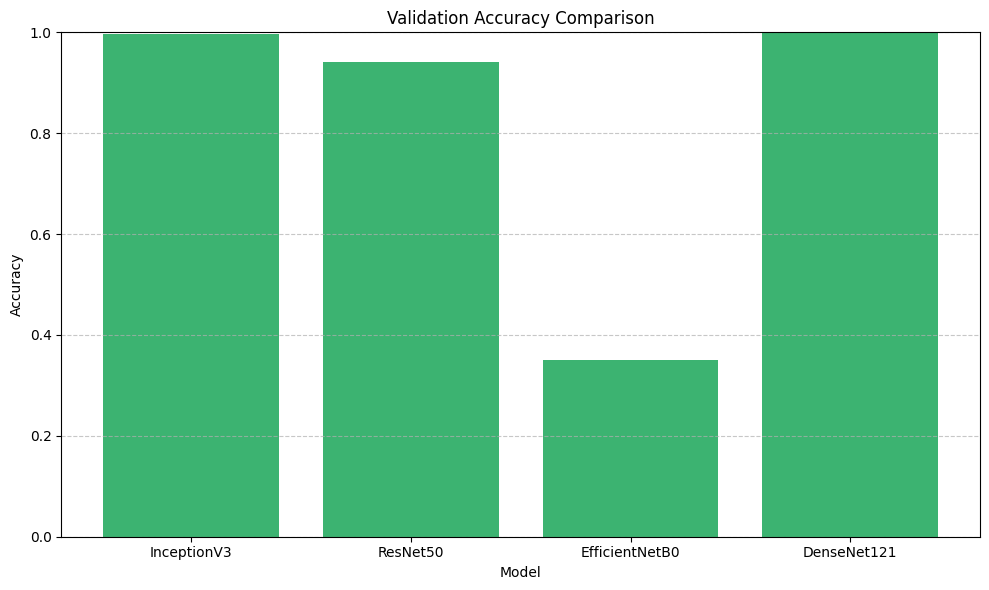

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df_comparison["Model"], df_comparison["Val Accuracy"], color="mediumseagreen")
plt.ylim(0, 1)
plt.title("Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

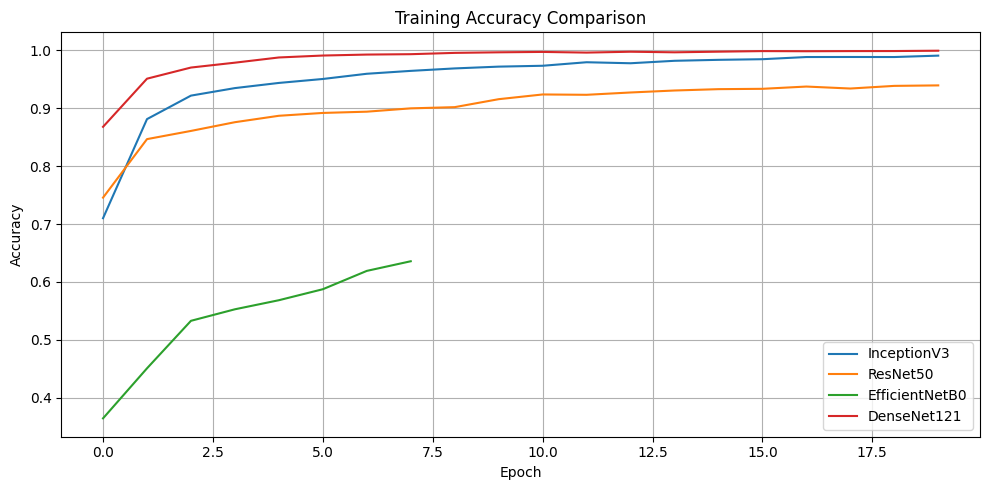

In [ ]:

plt.figure(figsize=(10, 5))

plt.plot(history_incep.history['accuracy'], label='InceptionV3')
plt.plot(history_resnet.history['accuracy'], label='ResNet50')
plt.plot(history_effnet.history['accuracy'], label='EfficientNetB0')
plt.plot(history_densenet.history['accuracy'], label='DenseNet121')

plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


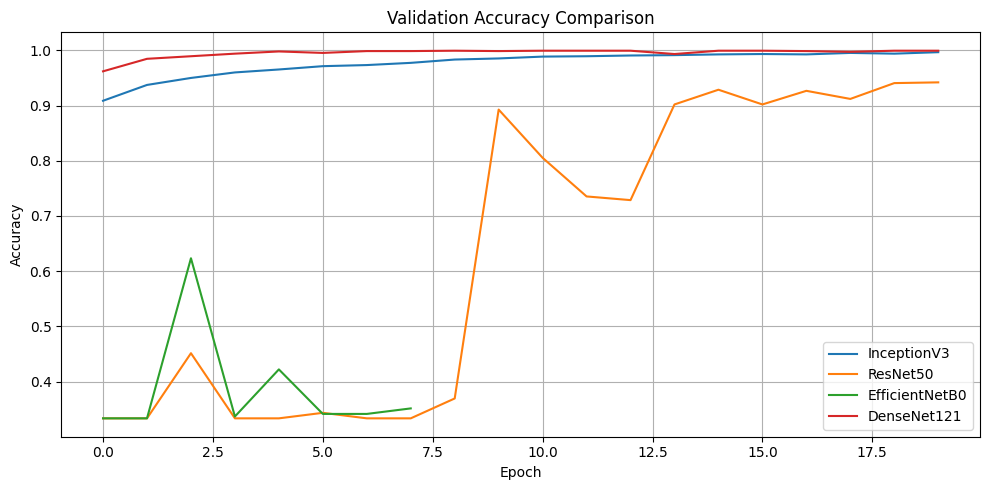

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(history_incep.history['val_accuracy'], label='InceptionV3')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50')
plt.plot(history_effnet.history['val_accuracy'], label='EfficientNetB0')
plt.plot(history_densenet.history['val_accuracy'], label='DenseNet121')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
test_loss_incep, test_acc_incep = model_incep.evaluate(test_generator)
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_generator)
test_loss_effnet, test_acc_effnet = model_effnet.evaluate(test_generator)
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(test_generator)


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 365ms/step - accuracy: 0.9856 - loss: 0.0429
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.9337 - loss: 0.1646
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 386ms/step - accuracy: 0.8397 - loss: 0.5813
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 376ms/step - accuracy: 1.0000 - loss: 1.5297e-04


In [ ]:
test_comparison_data = {
    "Model": ["InceptionV3", "ResNet50", "EfficientNetB0", "DenseNet121"],
    "Test Accuracy": [
        test_acc_incep,
        test_acc_resnet,
        test_acc_effnet,
        test_acc_densenet,
    ],
    "Test Loss": [
        test_loss_incep,
        test_loss_resnet,
        test_loss_effnet,
        test_loss_densenet,
    ]
}

df_test_comparison = pd.DataFrame(test_comparison_data)
df_test_comparison = df_test_comparison.round(4)
display(df_test_comparison)


,Model,Test Accuracy,Test Loss
0,InceptionV3,0.9920,0.0229
1,ResNet50,0.9447,0.1347
2,EfficientNetB0,0.6260,0.8828
3,DenseNet121,1.0000,0.0001


In [ ]:
import pickle

class_names = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]
with open("class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)
